In [1]:
from LABNET import Teacher

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import matplotlib.pyplot as plt

def plot_losses(losses, plot_size=(10, 5)):
    """
    Plot a list of losses and adjust the shape of the plot.

    Args:
        losses (list): List of loss values to be plotted.
        plot_size (tuple): Tuple specifying the size of the plot (width, height).

    Returns:
        None
    """
    # Set the plot size based on the provided tuple
    plt.figure(figsize=plot_size)
    
    # Create a line plot of the losses
    plt.plot(losses, label='Loss', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    # Show the plot
    plt.show()

In [4]:


n = 1000 #number of samples to generate
layer_sizes = [8, 7,7,4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
teacher = Teacher(layer_sizes)



In [5]:
teacher.configure()

In [6]:
teacher.generate_data(
    "train"
    ,n
    ,'normal'
    , m =0.0
    , std=1.0
)

In [7]:
teacher.train_inputs.shape

torch.Size([1000, 8])

In [8]:
teacher.generate_data(
    "val"
    ,n
    ,'normal'
    , m =0.0
    , std=1.0
)

In [9]:
teacher.val_inputs.shape

torch.Size([1000, 8])

In [10]:
teacher.model.state_dict()
#torch.save(neural_network.model.state_dict(), 'model_weights.pth')

OrderedDict([('input_layer.weight',
              tensor([[-0.3459,  0.3488, -0.4044,  0.8872,  0.5031, -0.3991, -0.9424,  0.1973],
                      [-0.8594,  0.7108,  0.2989,  0.6772, -0.5673, -0.7875,  0.6877,  0.3789],
                      [-0.2973, -0.6816,  0.4478, -0.7044,  0.3486,  0.4611,  0.1654, -0.4953],
                      [ 0.3697,  0.5130,  0.7928,  0.8617,  0.4193,  0.6137, -0.6991, -0.2097],
                      [-0.3042,  0.5370,  0.3162, -0.9906, -0.5854, -0.4078,  0.8200, -0.5859],
                      [-0.8483,  0.9041, -0.2322, -0.6018, -0.8396,  0.5694,  0.4749, -0.6996],
                      [-0.0675, -0.5282, -0.8343, -0.5772,  0.4847, -0.7250, -0.7393, -0.4801]])),
             ('input_layer.bias',
              tensor([-0.3896,  0.7506, -0.5311,  0.8903, -0.8489, -0.4250,  0.7781])),
             ('hidden_layer_2.weight',
              tensor([[-4.5743e-01, -1.9880e-01, -5.5980e-01,  1.3106e-01, -2.4884e-01,
                        3.4692e-01,  2.3

In [11]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        #self.hidden_3 = nn.Linear(7,7)
        #self.hidden_4 = nn.Linear(7,7)
        #self.hidden_5 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        #x = self.relu(self.hidden_3(x))
        #x = self.relu(self.hidden_4(x))
        #x = self.relu(self.hidden_5(x))
        x = self.output(x)
        return x

In [12]:
student = MyModel()
print(student)

MyModel(
  (hidden_1): Linear(in_features=8, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=4, bias=True)
  (relu): ReLU()
)


In [13]:
##STARTING with the right answuers gives some close to zero row_comp:3.5974587e-08,0.0,0.0; 0.0,2.9802322e-08,1.4901161e-08
#interesting that you get a zero, and then a close to zero.  
#perturb_weights(mymodel, std_dev = 0.005) # converges
#perturb_weights(mymodel, std_dev = 0.009) # converges
#perturb_weights(mymodel, std_dev = 0.05) doesn't converge
#perturb_weights(mymodel, std_dev = 0.01) #converges
#perturb_weights(mymodel, std_dev = 0.01) #not converging well, even with lower lr, 0.003. 1t 0.001


# scale_weights(mymodel, scaling_factor = 1.1) ## converges, weights cross.  
#scale_weights(mymodel, scaling_factor = 1.5) ## good validation, non zero row comapre still..

#scale_weights(mymodel, scaling_factor = 2) ## good validation, row compare stays pretty close to the same...
## scale_weights(mymodel, scaling_factor = 1.05) row compare barely improves!!
student.state_dict()

OrderedDict([('hidden_1.weight',
              tensor([[-0.3124, -0.3409,  0.2458, -0.0770,  0.2465,  0.3404, -0.2171, -0.2955],
                      [ 0.0675,  0.1391,  0.1650, -0.3087,  0.3149, -0.1683,  0.3154,  0.1694],
                      [ 0.0280,  0.0549,  0.0255,  0.1891, -0.1767, -0.2493,  0.0607, -0.0273],
                      [-0.1354,  0.1246,  0.0194, -0.0431, -0.0915, -0.3314, -0.1760, -0.1802],
                      [-0.3093,  0.2692,  0.1919,  0.0337,  0.1938,  0.1913, -0.0568,  0.0771],
                      [-0.2785,  0.3386, -0.2901, -0.0793, -0.3496, -0.0974,  0.2397, -0.0063],
                      [-0.0645, -0.1873, -0.3269,  0.3475, -0.1585, -0.1017, -0.2766, -0.0819]])),
             ('hidden_1.bias',
              tensor([-1.8766e-01,  1.0168e-01, -4.3331e-02,  1.0560e-01, -6.7875e-02,
                       5.5730e-06, -6.5335e-02])),
             ('hidden_2.weight',
              tensor([[-0.2324,  0.3026, -0.2314,  0.2150, -0.0851, -0.1486,  0.3571],
   

In [14]:
# Training loop
num_epochs = 100
batch_size = 32
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(student.parameters(), lr=learning_rate)

In [16]:
data = list(zip(teacher.train_inputs, teacher.train_targets))
input_tensors = torch.stack([torch.Tensor(x[0]) for x in data])
target_tensors = torch.stack([torch.Tensor(x[1]) for x in data])
dataset = TensorDataset(input_tensors, target_tensors)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:


losses = []  # List to store losses

for epoch in range(num_epochs):
    total_loss = 0
    for input_batch, target_batch in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        output = student(input_batch)  # Forward pass
        loss = criterion(output, target_batch)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        total_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/100], Loss: 0.0705
Epoch [2/100], Loss: 0.0489
Epoch [3/100], Loss: 0.0341
Epoch [4/100], Loss: 0.0252
Epoch [5/100], Loss: 0.0190
Epoch [6/100], Loss: 0.0158
Epoch [7/100], Loss: 0.0140
Epoch [8/100], Loss: 0.0132
Epoch [9/100], Loss: 0.0125
Epoch [10/100], Loss: 0.0120
Epoch [11/100], Loss: 0.0116
Epoch [12/100], Loss: 0.0113
Epoch [13/100], Loss: 0.0110
Epoch [14/100], Loss: 0.0105
Epoch [15/100], Loss: 0.0101
Epoch [16/100], Loss: 0.0097
Epoch [17/100], Loss: 0.0092
Epoch [18/100], Loss: 0.0088
Epoch [19/100], Loss: 0.0083
Epoch [20/100], Loss: 0.0080
Epoch [21/100], Loss: 0.0075
Epoch [22/100], Loss: 0.0071
Epoch [23/100], Loss: 0.0069
Epoch [24/100], Loss: 0.0068
Epoch [25/100], Loss: 0.0063
Epoch [26/100], Loss: 0.0062
Epoch [27/100], Loss: 0.0059
Epoch [28/100], Loss: 0.0057
Epoch [29/100], Loss: 0.0055
Epoch [30/100], Loss: 0.0053
Epoch [31/100], Loss: 0.0052
Epoch [32/100], Loss: 0.0048
Epoch [33/100], Loss: 0.0046
Epoch [34/100], Loss: 0.0043
Epoch [35/100], Loss: 0

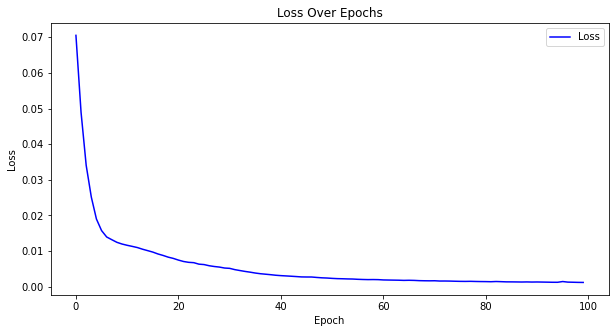

In [18]:
plot_losses(losses, plot_size=(10, 5))